In [8]:
import numpy as np
from pathlib import Path
from scipy import ndimage
from skimage import feature, measure, segmentation, util
from segmentflow import segment, view

In [1]:
def watershed_segment(
    imgs_binarized,
    min_peak_distance=1,
    use_int_dist_map=False,
    exclude_borders=False,
    print_size=False,
    return_dict=False,
    logger=None,
):
    """Create images with regions segmented and labeled using a watershed
    segmentation algorithm.
    ----------
    Parameters
    ----------
    binarized_imgs : numpy.ndarray
        3D DxMxN array representing D binary images with M rows and N columns
        to be used in segmentation.
    min_peak_distance : int or str, optional
        Minimum distance (in pixels) of local maxima to be used to generate
        seeds for watershed segmentation algorithm. 'median' can be passed to
        use the radius of the circle with equivalent area to the median
        binary region. Defaults to 1.
    use_int_dist_map : bool, optional
        If True, convert distance map to 16-bit array. Use with caution--
        changes segmentation results
    print_size : bool, optional
        If True, print the size of each item in the segmentation dictionary
        in GB. Defautls to False.
    return_dict : bool, optional
        If true, return dict, else return 3D array with pixels labeled
        corresponding to unique particle integers (see below)
    logger : logging.Logger, optional
        If not None, print statements will also be passed to a file determined
        at the creation of the Logger.
        See segmentflow.workflows.Workflow.create_logger. Defaults to None.
    -------
    Returns
    -------
    if return_dict == True :
        dict
            Dictionary of 3D DxMxN arrays the segmentation steps and labeled
            images. Keys for dict: 'binarized', 'distance-map',
            'maxima-points', 'maxima-mask', 'seeds', 'integer-labels'
    if return_dict == False :
        numpy.ndarray
            3D DxMxN array representing segmented images with pixels labeled
            corresponding to unique particle integers
    """
    if logger is None:
        print('Segmenting images...')
    else:
        logger.info('Segmenting images...')
    dist_map = ndimage.distance_transform_edt(imgs_binarized)
    if use_int_dist_map:
        dist_map = dist_map.astype(np.uint16)
    # If prompted, calculate equivalent median radius
    if min_peak_distance == 'median':
        regions = []
        for i in range(imgs_binarized.shape[0]):
            labels = measure.label(imgs_binarized[0, ...])
            regions += measure.regionprops(labels)
        areas = [region.area for region in regions]
        median_slice_area = np.median(areas)
        # Twice the radius of circle of equivalent area
        min_peak_distance = 2 * int(round(np.sqrt(median_slice_area) // np.pi))
        if logger is None:
            print(f'Calculated min_peak_distance: {min_peak_distance}')
        else:
            logger.info(f'Calculated min_peak_distance: {min_peak_distance}')
    # Calculate the local maxima with min_peak_distance separation
    maxima = feature.peak_local_max(
        dist_map,
        min_distance=min_peak_distance,
        exclude_border=False
    )
    # Assign a label to each point to use as seed for watershed seg
    maxima_mask = np.zeros_like(imgs_binarized, dtype=np.uint8)
    maxima_mask[tuple(maxima.T)] = 255
    seeds = measure.label(maxima_mask)
    # Release values to aid in garbage collection
    maxima_mask = None
    labels = segmentation.watershed(
        -1 * dist_map.astype(np.int32), seeds.astype(np.int32),
        mask=imgs_binarized.astype(np.int32)
    )
    # Convert labels to smaller datatype is number of labels allows
    if np.max(labels) < 2**8:
        labels = labels.astype(np.uint8)
    elif np.max(labels) < 2**16:
        labels = labels.astype(np.uint16)
    # Release values to aid in garbage collection
    seeds = None
    # Count number of particles segmented
    n_particles = np.max(labels)
    if exclude_borders:
        if logger is None:
            print('Excluding borders...')
        else:
            logger.info('Excluding borders...')
        if logger is None:
            print(
                '--> Number of particle(s) before border exclusion: ',
                str(n_particles))
        else:
            logger.info(
                '--> Number of particle(s) before border exclusion: ',
                str(n_particles))
        labels = segmentation.clear_border(labels)
        # Calculate number of instances of each value in label_array
        particleIDs = np.unique(labels)
        # Subtract 1 to account for background label
        n_particles = len(particleIDs) - 1
    if logger is None:
        print(
            f'--> Segmentation complete. '
            f'{n_particles} particle(s) segmented.')
    else:
        logger.info(
            f'--> Segmentation complete. '
            f'{n_particles} particle(s) segmented.')
    if print_size:
        # sys.getsizeof() doesn't represent nested objects; need to add manually
        if logger is None:
            print('--> Size of segmentation results (GB):')
        else:
            logger.info('--> Size of segmentation results (GB):')
        for key, val in segment_dict.items():
            if logger is None:
                print(f'----> {key}: {sys.getsizeof(val) / 1E9}')
            else:
                logger.info(f'----> {key}: {sys.getsizeof(val) / 1E9}')
    if return_dict:
        segment_dict = {
            'distance-map' : dist_map,
            'maxima' : maxima,
            'integer-labels' : labels,
        }
        return segment_dict
    else:
        return labels

In [11]:
imgs_dir_path = Path(
    r'C:\Users\gusb\Research\mhe-analysis\data\2p06_voxelize_original_stls')
imgs = segment.load_images(
    imgs_dir_path,
    slice_crop=[200, 800],
    row_crop=[200, 800],
    col_crop=[200, 800],
    file_suffix='.tif'
)

Loading images...
--> Images loaded as 3D array:  (600, 600, 600)


--> Plotting images: [100, 300, 500]


(<Figure size 750x250 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

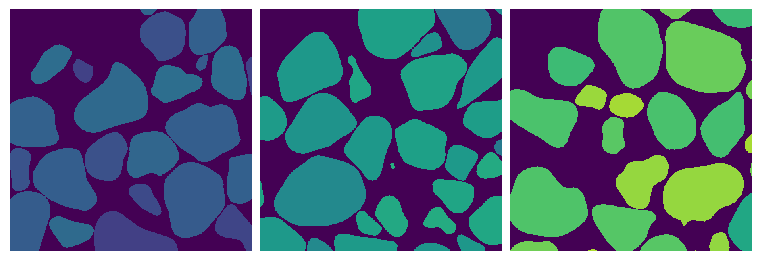

In [12]:
slices = [100, 300, 500]
view.vol_slices(imgs, slices=slices)

--> Plotting images: [100, 300, 500]


(<Figure size 750x250 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

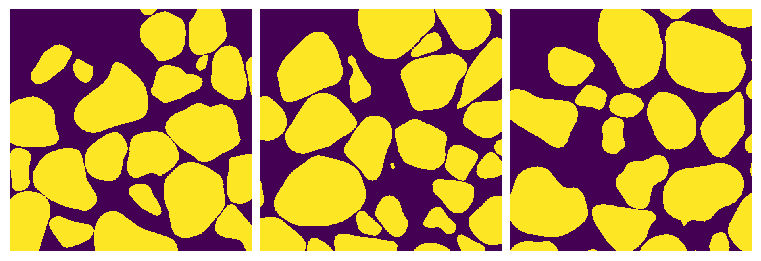

In [13]:
imgs[imgs > 1] = 1
imgs = util.img_as_uint(imgs)
view.vol_slices(imgs, slices=slices)

--> Plotting images: [100, 300, 500]


(<Figure size 750x250 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

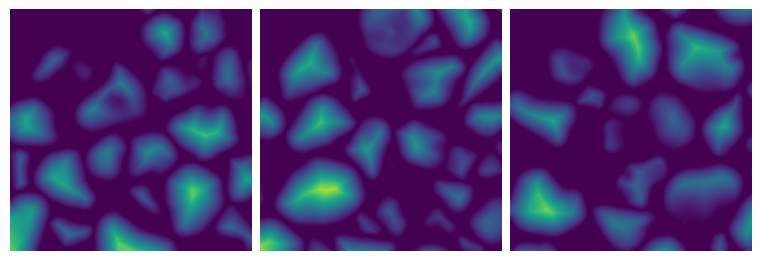

In [14]:
dist_map = ndimage.distance_transform_edt(imgs)
view.vol_slices(dist_map, slices=slices)

In [15]:
maxima = feature.peak_local_max(
    dist_map,
    min_distance=1,
    exclude_border=False
)
maxima.shape

(7656, 3)

In [ ]:
# Move in multiples of 8 (2**3) so the number scales between the three
# resolution doublings
# F50 sand
#  0.2% retained at  75um diameter
#  3.2% retained at 106um diameter
# 18.2% retained at 150um diameter
# 55.2% retained at 212um diameter
# 89.2% retained at 300um diameter

# Ratio of prism to cylinder
# pi*(d/2)**2*h / d*d*h
# pi*d**2*h/4 / d*d*h
# pi*d**2/4 / d*d
# pi*d/4 / d
# pi/4

og_vol = 1200*1920*1920
vol = imgs.shape[0]*imgs.shape[1]*imgs.shape[2]
scale = og_vol / vol

for i in range(5, 15):
    print('Resolutions in pixels:')
    dist_pixels = [i*2**f for f in [0, 1, 2]]
    print(', '.join([str(v) for v in dist_pixels]))
    print('Resolutions in microns:')
    dist_microns = [p*2.06 for p in dist_pixels]
    print(', '.join([str(v) for v in dist_microns]))
    this_msd = dist_pixels[2]
    maxima = feature.peak_local_max(
        dist_map,
        min_distance=this_msd,
        exclude_border=False
    )
    print('Estimated grains for full volume:')
    print(int(scale * maxima.shape[0] * np.pi/4), 'segmented regions')
    print()

Resolutions in pixels:
5, 10, 20
Resolutions in microns:
10.3, 20.6, 41.2
Estimated grains for full volume:
2557 segmented regions

Resolutions in pixels:
6, 12, 24
Resolutions in microns:
12.36, 24.72, 49.44
Estimated grains for full volume:
2444 segmented regions

Resolutions in pixels:
7, 14, 28
Resolutions in microns:
14.42, 28.84, 57.68
Estimated grains for full volume:
2284 segmented regions

Resolutions in pixels:
8, 16, 32
Resolutions in microns:
16.48, 32.96, 65.92
Estimated grains for full volume:
2107 segmented regions

Resolutions in pixels:
9, 18, 36
Resolutions in microns:
18.54, 37.08, 74.16
Estimated grains for full volume:
1994 segmented regions

Resolutions in pixels:
10, 20, 40
Resolutions in microns:
20.6, 41.2, 82.4
Estimated grains for full volume:
1914 segmented regions

Resolutions in pixels:
11, 22, 44
Resolutions in microns:
22.66, 45.32, 90.64
Estimated grains for full volume:
1785 segmented regions

Resolutions in pixels:
12, 24, 48
Resolutions in microns:
2

In [ ]:
test = [p* 2.06 for p in [1, 2, 3]]

2.06, 4.12, 6.18


In [ ]:
# Move in multiples of 8 (2**3) so the number scales between the three
# resolution doublings
# F50 sand
#  0.2% retained at  75um diameter (75/2.06 = )
#  3.2% retained at 106um diameter
# 18.2% retained at 150um diameter
# 55.2% retained at 212um diameter
# 89.2% retained at 300um diameter
og_vol = 1200*1920*1920
vol = imgs.shape[0]*imgs.shape[1]*imgs.shape[2]
scale = og_vol / vol

for i in range(5, 10):
    print(i, 'pixels (smallest resolution)')
    dist_pixels = i*2**3
    dist_microns = dist_pixels * 2.06
    print(dist_microns, ' microns')
    print(dist_pixels, ' pixels')
    maxima = feature.peak_local_max(
        dist_map,
        min_distance=dist_pixels,
        exclude_border=False
    )
    print('Estimated grains for full volume:')
    print(int(scale * maxima.shape[0]), 'segmented regions')
    print()

5 pixels (smallest resolution)
82.4  microns
40  pixels
Estimated grains for full volume:
2437 segmented regions

6 pixels (smallest resolution)
98.88  microns
48  pixels
Estimated grains for full volume:
2088 segmented regions

7 pixels (smallest resolution)
115.36  microns
56  pixels
Estimated grains for full volume:
1863 segmented regions

8 pixels (smallest resolution)
131.84  microns
64  pixels
Estimated grains for full volume:
1617 segmented regions

9 pixels (smallest resolution)
148.32  microns
72  pixels
Estimated grains for full volume:
1331 segmented regions



(65, 3)

Estimated grains for full volume:
1331


In [44]:
7*2**3

56

In [45]:
10*2**3

80

In [ ]:
# Assign a label to each point to use as seed for watershed seg
maxima_mask = np.zeros_like(imgs, dtype=np.uint8)
maxima_mask[tuple(maxima.T)] = 255
seeds = measure.label(maxima_mask)
# Release values to aid in garbage collection
maxima_mask = None
labels = segmentation.watershed(
    -1 * dist_map.astype(np.int32), seeds.astype(np.int32),
    mask=imgs.astype(np.int32)
)
# Convert labels to smaller datatype is number of labels allows
if np.max(labels) < 2**8:
    labels = labels.astype(np.uint8)
elif np.max(labels) < 2**16:
    labels = labels.astype(np.uint16)
# Release values to aid in garbage collection
seeds = None
# Count number of particles segmented
n_particles = np.max(labels)
print(n_particles)
view.vol_slices(labels)

KeyboardInterrupt: 

(<Figure size 2250x750 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

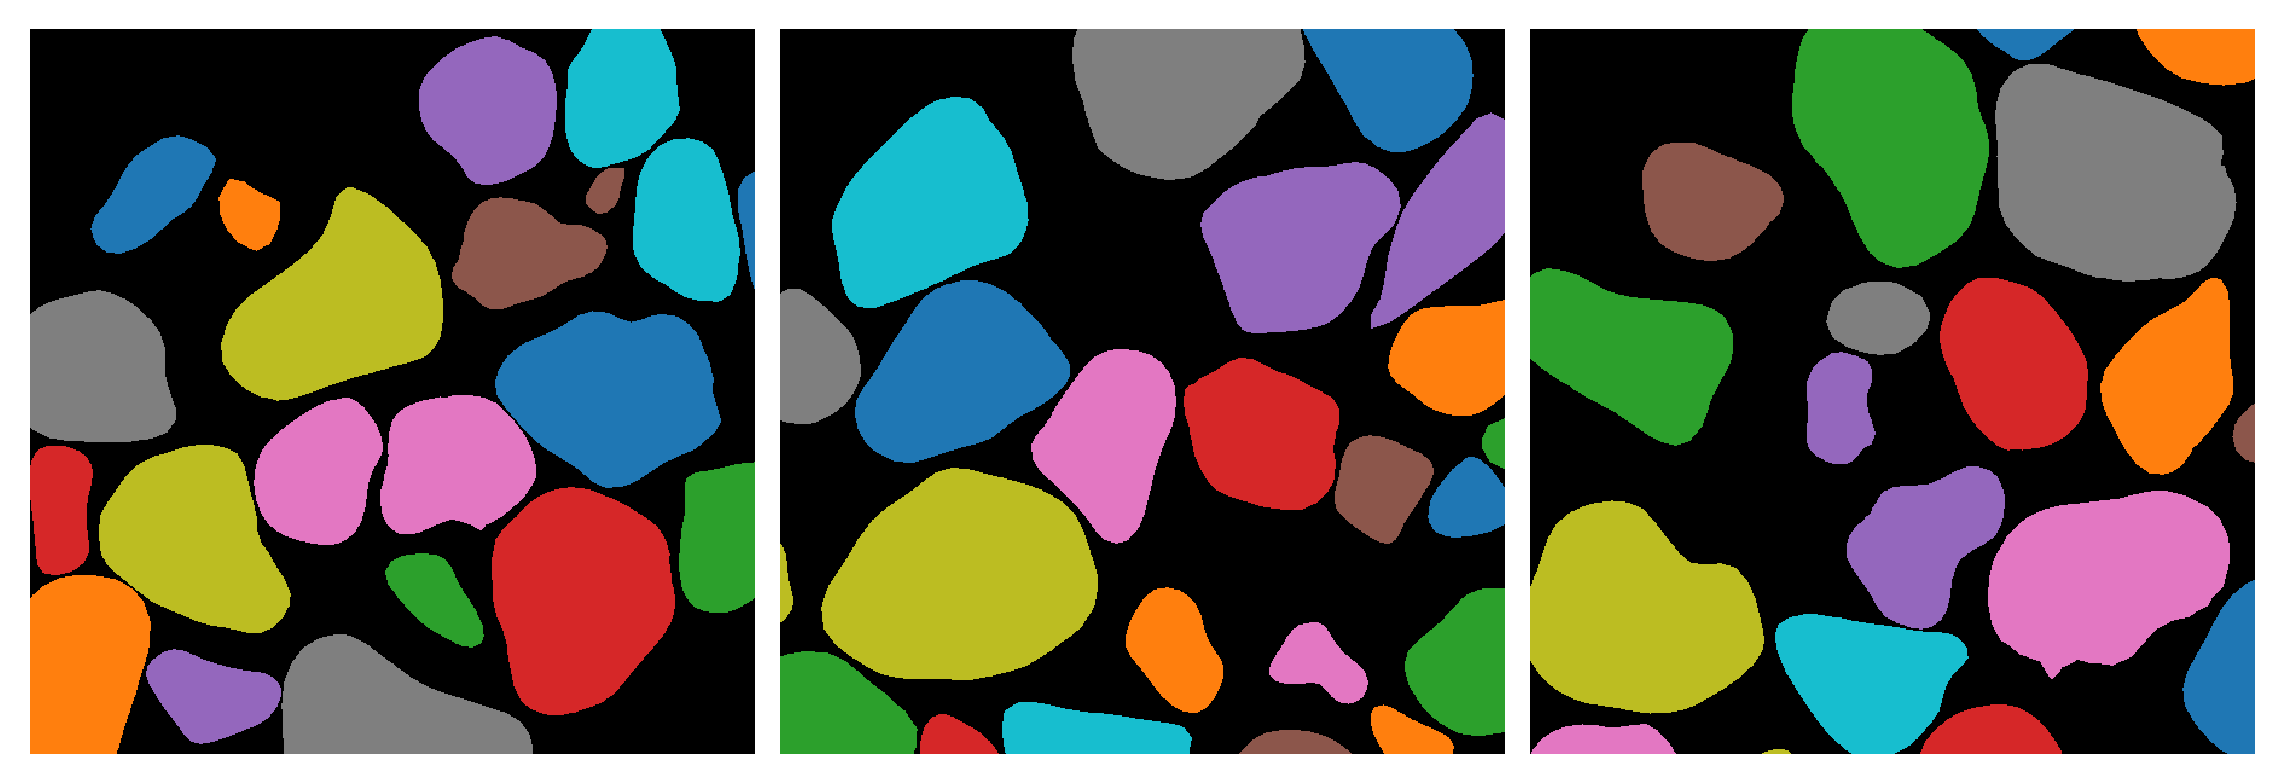

In [ ]:
view.color_labels(labels, slices=slices)